In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns
from ipywidgets import interactive

import datetime
import tensorflow as tf
from tensorflow import keras

import math 
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp


from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

Using TensorFlow backend.


In [2]:
crime = pd.read_csv('...crimetodate_cleaneddata.csv')
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399636 entries, 0 to 399635
Data columns (total 20 columns):
Unnamed: 0             399636 non-null int64
INCIDENT_NUMBER        399636 non-null object
OFFENSE_CODE           399636 non-null int64
OFFENSE_CODE_GROUP     399636 non-null object
OFFENSE_DESCRIPTION    399636 non-null object
DISTRICT               397816 non-null object
REPORTING_AREA         399636 non-null object
SHOOTING               399636 non-null int64
YEAR                   399636 non-null int64
MONTH                  399636 non-null int64
DAY_OF_WEEK            399636 non-null object
HOUR                   399636 non-null int64
UCR_PART               399527 non-null object
STREET                 397111 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location_lat           399636 non-null float64
Location_long          399636 non-null float64
date_occured           399636 non-null object
occured_on_dttm  

In [3]:
crime.Lat.replace(-1,None,inplace=True)
crime.Long.replace(-1,None,inplace=True)

In [4]:
offense_filter=crime.groupby(['OFFENSE_CODE_GROUP']
              ,as_index=False).agg({"INCIDENT_NUMBER":"count"}).sort_values(by='INCIDENT_NUMBER'
                                                                            , ascending=False).reset_index(drop=False)
offense_filter['cumsum1']=offense_filter.INCIDENT_NUMBER.cumsum()
offense_filter['pct_cummulative']=[i/(len(crime.INCIDENT_NUMBER)+1)  for i in offense_filter.cumsum1]

offense_filter = offense_filter[offense_filter.pct_cummulative <= .70]

crime=crime[crime.OFFENSE_CODE_GROUP.isin(offense_filter.OFFENSE_CODE_GROUP)]

In [5]:
max(crime.Long)

-70.96436489

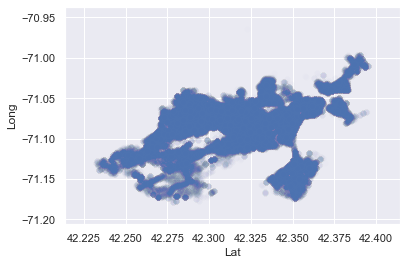

In [6]:
sns.set()
sns.scatterplot(x='Lat',y='Long', data=crime, alpha=0.01)
plt.show()

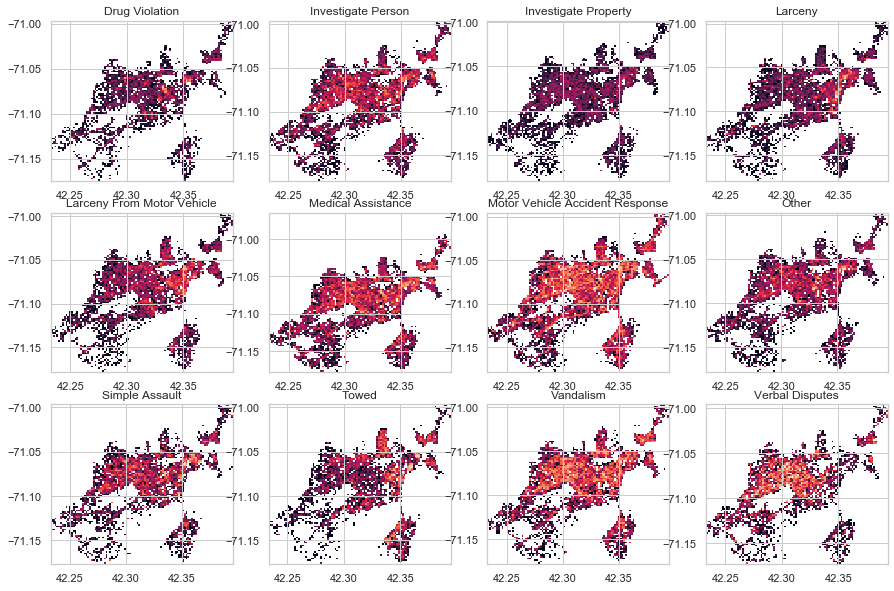

In [7]:
NX=100
NY=100
groups = crime.groupby('OFFENSE_CODE_GROUP')
ii=1
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
for name, group in groups:
    plt.subplot(3,4,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.Lat),np.array(group.Long), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
    ii+=1
del groups

## Data Cleaning and Feature Engineering

In [8]:
labels = crime['OFFENSE_CODE_GROUP'].astype('category').cat.categories.tolist()
replace_with_int = {'OFFENSE_CODE_GROUP' : {k: v for k,v in zip(labels,list(range(0,len(labels))))}}

In [9]:
replace_with_int

{'OFFENSE_CODE_GROUP': {'Drug Violation': 0,
  'Investigate Person': 1,
  'Investigate Property': 2,
  'Larceny': 3,
  'Larceny From Motor Vehicle': 4,
  'Medical Assistance': 5,
  'Motor Vehicle Accident Response': 6,
  'Other': 7,
  'Simple Assault': 8,
  'Towed': 9,
  'Vandalism': 10,
  'Verbal Disputes': 11}}

## Running Chi-Squared Test to Test the Significant Relationship between Independent Var vs Dependent Var

In [10]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scs.chi2_contingency(ctsum.fillna(0)))

In [11]:
#Result for all below is : there is a significant relationship
print("District and Offense Coude Group"
      ,"Chi Squared Value :", chisq_of_df_cols(crime, 'DISTRICT','OFFENSE_CODE_GROUP')[0]
      ,"P-Value :", chisq_of_df_cols(crime, 'DISTRICT','OFFENSE_CODE_GROUP')[1]
     ,sep = "\n")

print("Reporting Area and Offense Coude Group"
      ,"Chi Squared Value :", chisq_of_df_cols(crime, 'REPORTING_AREA','OFFENSE_CODE_GROUP')[0]
      ,"P-Value :", chisq_of_df_cols(crime, 'REPORTING_AREA','OFFENSE_CODE_GROUP')[1]
     ,sep = "\n")
print("Day of Week and Offense Coude Group"
      ,"Chi Squared Value :", chisq_of_df_cols(crime, 'DAY_OF_WEEK','OFFENSE_CODE_GROUP')[0]
      ,"P-Value :", chisq_of_df_cols(crime, 'DAY_OF_WEEK','OFFENSE_CODE_GROUP')[1]
     ,sep = "\n")
print("Street and Offense Coude Group"
      ,"Chi Squared Value :", chisq_of_df_cols(crime, 'STREET','OFFENSE_CODE_GROUP')[0]
      ,"P-Value :", chisq_of_df_cols(crime, 'STREET','OFFENSE_CODE_GROUP')[1]
     ,sep = "\n")

District and Offense Coude Group
Chi Squared Value :
25073.135674672336
P-Value :
0.0
Reporting Area and Offense Coude Group
Chi Squared Value :
129891.69557937903
P-Value :
0.0
Day of Week and Offense Coude Group
Chi Squared Value :
1817.9993218058914
P-Value :
0.0
Street and Offense Coude Group
Chi Squared Value :
176307.21477372223
P-Value :
0.0


In [12]:
##Categorizing the season column using Dummy Vars : the reason is because there is no Hierarchy..
#meaning that, "Fall IS NOT Higher or Better than Summer"

def data_prep(df_clean):
    
    #date time split 2019-10-13 09:28:24
    def parse_time(x):
        DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
        time=DD.hour 
        day=DD.day
        month=DD.month
        year=DD.year
        mins=DD.minute
        return time,day,month,year,mins
    
    parsed = np.array([parse_time(x) for x in df_clean.occured_on_dttm])
    
    df_clean['Dates'] = pd.to_datetime(df_clean['occured_on_dttm'])
    df_clean['WeekOfYear'] = df_clean['Dates'].dt.weekofyear
    df_clean['Hour'] = parsed[:,[0]]
    df_clean['day'] = parsed[:,[1]]
    df_clean['month'] = parsed[:,[2]]
    df_clean['year'] = parsed[:,[3]]
    df_clean['mins'] = parsed[:,[4]]
    
    
        
    #adding season variable
    def get_season(x):
        if x in [5, 6, 7]:
            r = 'summer'
        elif x in [8, 9, 10]:
            r = 'fall'
        elif x in [11, 12, 1]:
            r = 'winter'
        elif x in [2, 3, 4]:
            r = 'spring'
        return r
    
    df_clean['season'] = [get_season(i) for i in crime.MONTH]
        
        
    #grouping street       
    streetcount = df_clean.groupby(['STREET'], as_index=False).agg({"INCIDENT_NUMBER":"count"}).sort_values(by='INCIDENT_NUMBER', ascending=False).head(8)
    streetcount['odds'] = [round(i/(len(df_clean.STREET)+1),3) for i in streetcount.INCIDENT_NUMBER]
    streetcount.drop(['INCIDENT_NUMBER'],axis=1,inplace=True)
    df_clean = pd.merge(left=df_clean,right=streetcount,how='left',left_on='STREET',right_on='STREET')
    
    
    #dummy variables
    df_clean_onehot = pd.get_dummies(df_clean, columns=['season'], prefix = [''])
    s = (len(list(df_clean_onehot.columns))-len(df_clean.season.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,s:]], axis=1)

    ##Categorizing the DayOFWeek column using Dummy Vars 
    df_clean_onehot = pd.get_dummies(df_clean, columns=['DAY_OF_WEEK'], prefix = [''])
    l = (len(list(df_clean_onehot.columns))-len(df_clean.DAY_OF_WEEK.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,l:]],axis=1)

    ##Categorizing the MONTH column using Dummy Vars : the reason is because there is no Hierarchy..
    #meaning that, "FEB IS NOT Higher or Better than JAN"
    #This insight was shown from the EDA result (forecasting data with trend might be a different case)

    df_clean_onehot = pd.get_dummies(df_clean, columns=['month'], prefix = ['month'])
    n = (len(list(df_clean_onehot.columns))-len(df_clean.MONTH.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,n:]],axis=1)

    ##Categorizing the District column using Dummy Vars 

    df_clean_onehot = pd.get_dummies(df_clean, columns=['DISTRICT'], prefix = [''])
    o = (len(list(df_clean_onehot.columns))-len(df_clean.DISTRICT.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,o:]],axis=1)

    ##changing the Output Variables to integer
    labels = df_clean['OFFENSE_CODE_GROUP'].astype('category').cat.categories.tolist()
    replace_with_int = {'OFFENSE_CODE_GROUP' : {k: v for k,v in zip(labels,list(range(0,len(labels))))}}
    df_clean.replace(replace_with_int, inplace=True)

    #Normalizing the columns
    def norm_func(i):
        r = (i-min(i))/(max(i)-min(i))
        return(r)

    df_clean['normHour']=norm_func(df_clean.HOUR)
    df_clean['normmins']=norm_func(df_clean.mins)
    df_clean['normdate_day']=norm_func(df_clean.day)
    df_clean['normLat']=norm_func(df_clean.Lat)
    df_clean['normLong']=norm_func(df_clean.Long)
    df_clean['normmonth']=norm_func(df_clean.month)
    df_clean['normyear']=norm_func(df_clean.year)
    df_clean['normWeekOfYear']=norm_func(df_clean.WeekOfYear)



    ##removing the unused columns
    df_clean.drop(columns = [ 'Unnamed: 0', 'INCIDENT_NUMBER', 'OFFENSE_CODE',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'YEAR',
       'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Lat', 'Long',
       'Location_lat', 'Location_long', 'date_occured', 'occured_on_dttm','Dates',
        'WeekOfYear','Hour','day','month','year','mins','season'], axis = 1,inplace=True)
    return(df_clean)

In [13]:
crime_clean = data_prep(crime)
crime_clean.columns

Index(['OFFENSE_CODE_GROUP', 'odds', '_fall', '_spring', '_summer', '_winter',
       '_Friday', '_Monday', '_Saturday', '_Sunday', '_Thursday', '_Tuesday',
       '_Wednesday', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', '_A1', '_A15', '_A7', '_B2', '_B3', '_C11', '_C6', '_D14',
       '_D4', '_E13', '_E18', '_E5', 'normHour', 'normmins', 'normdate_day',
       'normLat', 'normLong', 'normmonth', 'normyear', 'normWeekOfYear'],
      dtype='object')

In [14]:
def one_hot_var(df_clean):
    df_clean['street_odds']=np.where(df_clean.odds.isna(),0,df_clean.odds)
    
    df_clean_onehot = pd.get_dummies(df_clean, columns=['street_odds'], prefix = ['street_odds'])
    v = (len(list(df_clean_onehot.columns))-len(df_clean.street_odds.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,v:]],axis=1)
    df_clean.drop(columns =['odds','street_odds'], axis = 1,inplace=True)
    
    return(df_clean)

In [15]:
crime_clean= one_hot_var(crime_clean)
crime_clean.drop(['street_odds_0.0'], axis=1,inplace =True)

## Splitting the Train & Test Data for Model

In [16]:
split = np.random.rand(len(crime_clean)) < 0.8
train = crime_clean[split]
test = crime_clean[~split]

In [17]:
print('entire dataset :',len(crime_clean.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')
print('train dataset :',len(crime_clean.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')
print('test dataset :',len(crime_clean.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')

entire dataset : 12 offense codes
train dataset : 12 offense codes
test dataset : 12 offense codes


In [18]:
#test.to_csv('/Users/jenniferwu/Desktop/MSBA/Fall 2019/Data Analytics/Bostontest_raw.csv',encoding='utf-8', index=False)

## Checking Train Data

In [19]:
train = train.reset_index(drop = True)
train.head()

,OFFENSE_CODE_GROUP,_fall,_spring,_summer,_winter,_Friday,_Monday,_Saturday,_Sunday,_Thursday,...,normdate_day,normLat,normLong,normmonth,normyear,normWeekOfYear,street_odds_0.015,street_odds_0.016,street_odds_0.023,street_odds_0.047
0,2,1,0,0,0,0,0,0,1,0,...,0.933333,0.280089,0.402273,0.727273,1.0,0.730769,0,0,0,0
1,1,1,0,0,0,0,0,0,1,0,...,0.933333,0.831817,0.526391,0.727273,1.0,0.730769,0,0,0,0
2,10,1,0,0,0,0,0,0,1,0,...,0.933333,0.365265,0.495699,0.727273,1.0,0.730769,0,0,0,0
3,10,1,0,0,0,0,0,0,1,0,...,0.933333,0.811162,0.538851,0.727273,1.0,0.730769,0,0,0,0
4,2,1,0,0,0,0,0,0,1,0,...,0.933333,0.345597,0.246720,0.727273,1.0,0.730769,0,0,0,0


## Checking Test Data

In [20]:
test
test.head()

,OFFENSE_CODE_GROUP,_fall,_spring,_summer,_winter,_Friday,_Monday,_Saturday,_Sunday,_Thursday,...,normdate_day,normLat,normLong,normmonth,normyear,normWeekOfYear,street_odds_0.015,street_odds_0.016,street_odds_0.023,street_odds_0.047
3,11,1,0,0,0,0,0,0,1,0,...,0.933333,0.365265,0.495699,0.727273,1.0,0.730769,0,0,0,0
4,6,1,0,0,0,0,0,0,1,0,...,0.933333,0.614934,0.483697,0.727273,1.0,0.730769,0,0,0,0
5,1,1,0,0,0,0,0,0,1,0,...,0.933333,0.866875,0.663510,0.727273,1.0,0.730769,0,0,0,0
9,6,1,0,0,0,0,0,0,1,0,...,0.933333,0.339211,0.482484,0.727273,1.0,0.730769,0,0,0,0
19,10,1,0,0,0,0,0,0,1,0,...,0.933333,0.651720,0.126406,0.727273,1.0,0.730769,0,0,0,0


## Training the neural network model

In [21]:
##Change df into np.array since Tensorflow works w array

trainnparray = train.values

TrainData   = trainnparray[:, 1:]
TrainLabels = trainnparray[:, [0]]

TrainLabels = TrainLabels.astype('float32')
TrainData = TrainData.astype('float32')

trainnparray.shape

(216985, 48)

# Model 1 - Used all variables, 1 layer, 20 epoch

In [22]:
from sklearn.metrics import roc_auc_score

model = Sequential()
model.add(Dense(12, input_shape=(47,)))
#model.add(Dense(128, activation='relu', input_dim=512))
model.add(Dense(90, activation='relu', input_dim=128))
model.add(Dense(12, activation='softmax', input_dim=90))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# The fit() method - trains the model
model.fit(TrainData, TrainLabels, nb_epoch=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
216985/216985 [==============================] - 7s 34us/step - loss: 2.3499 - accuracy: 0.1841
Epoch 2/20
216985/216985 [==============================] - 6s 30us/step - loss: 2.3141 - accuracy: 0.1961 0s
Epoch 3/20
216985/216985 [==============================] - 6s 28us/step - loss: 2.2980 - accuracy: 0.2019 1s - loss: 2.2989 - accura - E
Epoch 4/20
216985/216985 [==============================] - 7s 33us/step - loss: 2.2897 - accuracy: 0.2049
Epoch 5/20
216985/216985 [==============================] - 7s 30us/step - loss: 2.2855 - accuracy: 0.2058
Epoch 6/20
216985/216985 [==============================] - 7s 31us/step - loss: 2.2820 - accuracy: 0.2076
Epoch 7/20
216985/216985 [==============================] - 7s 30us/step - loss: 2.2798 - accuracy: 0.2080
Epoch 8/20
216985/216985 [==============================] - 6s 30us/step - loss: 2.2774 - accuracy: 0.2090
Epoch 9/20
216985/216985 [==============================] - 7s 30us/step - loss: 2.2760 - accuracy: 0.2093
Epo

## Evaluate the model on the cleaned test data

In [23]:
##Change df into np.arrat since Tensorflow works w array
testnparray = test.values


TestData   = testnparray[:,1:]
TestLabels = testnparray[:, [0]]

TestLabels = TestLabels.astype('float32')
TestData = TestData.astype('float32')

In [24]:
test_loss, test_acc = model.evaluate(TestData, TestLabels)  
print('Test Loss:', test_loss,
      'Test Accuracy:',test_acc,
       sep = '\n')

54638/54638 [==============================] - 1s 14us/step
Test Loss:
2.2633479155106166
Test Accuracy:
0.21847432851791382


# Model 2 - Dropped street grouping variables, 2 layers, 20 epoch

In [25]:
train1 = train.iloc[:,:44]

In [26]:
##Change df into np.array since Tensorflow works w array

train1nparray = train1.values

Train1Data   = train1nparray[:, 1:]
Train1Labels = train1nparray[:, [0]]

Train1Labels = Train1Labels.astype('float32')
Train1Data = Train1Data.astype('float32')

train1nparray.shape

(216985, 44)

In [27]:
model1 = Sequential()
model1.add(Dense(12, input_shape=(43,)))
model1.add(Dense(128, activation='relu', input_dim=512))
model1.add(Dense(90, activation='relu', input_dim=128))
model1.add(Dense(12, activation='softmax', input_dim=90))
model1.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# The fit() method - trains the model
model1.fit(Train1Data, Train1Labels, nb_epoch=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/20
216985/216985 [==============================] - 8s 38us/step - loss: 2.3569 - accuracy: 0.1826
Epoch 2/20
216985/216985 [==============================] - 9s 40us/step - loss: 2.3195 - accuracy: 0.1925
Epoch 3/20
216985/216985 [==============================] - 8s 38us/step - loss: 2.3075 - accuracy: 0.1963
Epoch 4/20
216985/216985 [==============================] - 8s 36us/step - loss: 2.3006 - accuracy: 0.1991
Epoch 5/20
216985/216985 [==============================] - 7s 34us/step - loss: 2.2946 - accuracy: 0.2015
Epoch 6/20
216985/216985 [==============================] - 8s 35us/step - loss: 2.2886 - accuracy: 0.2036 0s - loss: 2.2887 - accuracy: 0.20
Epoch 7/20
216985/216985 [==============================] - 7s 32us/step - loss: 2.2841 - accuracy: 0.2061 0s - los
Epoch 8/20
216985/216985 [==============================] - 7s 32us/step - loss: 2.2798 - accuracy: 0.2090
Epoch 9/20
216985/216985 [==============================] - 7s 33us/step - loss: 2.2753 - accuracy: 

In [28]:
##Change df into np.arrat since Tensorflow works w array
test1 = test.iloc[:,:44]

test1nparray = test1.values


Test1Data   = test1nparray[:,1:]
Test1Labels = test1nparray[:, [0]]

Test1Labels = Test1Labels.astype('float32')
Test1Data = Test1Data.astype('float32')

In [29]:
test_loss, test_acc = model1.evaluate(Test1Data, Test1Labels)  
print('Test Loss:', test_loss,
      'Test Accuracy:',test_acc,
       sep = '\n')

54638/54638 [==============================] - 1s 15us/step
Test Loss:
2.2566811632170127
Test Accuracy:
0.22220799326896667


# Model 3 : All components matched with Model 1 but with additional layer

In [30]:
model2 = Sequential()
model2.add(Dense(12, input_shape=(47,)))
model2.add(Dense(128, activation='relu', input_dim=512))
model2.add(Dense(90, activation='relu', input_dim=128))
model2.add(Dense(12, activation='softmax', input_dim=90))
model2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# The fit() method - trains the model
model2.fit(TrainData, TrainLabels, nb_epoch=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/20
216985/216985 [==============================] - 8s 38us/step - loss: 2.3489 - accuracy: 0.1856
Epoch 2/20
216985/216985 [==============================] - 9s 41us/step - loss: 2.3070 - accuracy: 0.1985
Epoch 3/20
216985/216985 [==============================] - 7s 33us/step - loss: 2.2914 - accuracy: 0.2036
Epoch 4/20
216985/216985 [==============================] - 7s 32us/step - loss: 2.2843 - accuracy: 0.2070
Epoch 5/20
216985/216985 [==============================] - 7s 34us/step - loss: 2.2796 - accuracy: 0.2088
Epoch 6/20
216985/216985 [==============================] - 7s 33us/step - loss: 2.2758 - accuracy: 0.2095 0s - loss: 2.2
Epoch 7/20
216985/216985 [==============================] - 7s 32us/step - loss: 2.2724 - accuracy: 0.2108
Epoch 8/20
216985/216985 [==============================] - 7s 32us/step - loss: 2.2686 - accuracy: 0.2120
Epoch 9/20
216985/216985 [==============================] - 7s 32us/step - loss: 2.2653 - accuracy: 0.2137
Epoch 10/20
216985/216

In [31]:
##Change df into np.arrat since Tensorflow works w array
test2nparray = test.values


Test2Data   = test2nparray[:,1:]
Test2Labels = test2nparray[:, [0]]

Test2Labels = Test2Labels.astype('float32')
Test2Data = Test2Data.astype('float32')

In [32]:
test_loss, test_acc = model.evaluate(Test2Data, Test2Labels)  
print('Test Loss:', test_loss,
      'Test Accuracy:',test_acc,
       sep = '\n')

54638/54638 [==============================] - 1s 15us/step
Test Loss:
2.2633479155106166
Test Accuracy:
0.21847432851791382


##### ******Note : Choose model 2 because the first and third model overfits on train data

## Prediction Output

In [33]:
#Now Exporting the predictions
predictions = model1.predict_proba(Test1Data)
predictiondata=pd.DataFrame(data=predictions) 
predictiondata.drop([0], axis =1, inplace = True) #removing the 0th class auto created by TF
predictiondata.rename(columns = {i:j for i,j in zip(predictiondata.columns,labels)}, inplace = True)
predictiondata['MaxProb'] = [np.max(i) for i in predictions]
predictiondata['MaxProbLabel'] = [labels[np.argmax(i)] for i in predictions]

In [34]:
#predictiondata.to_csv('/Users/jenniferwu/Desktop/MSBA/Fall 2019/Data Analytics/Bostonpredictionoutput.csv'
#                      ,encoding='utf-8', index=False)
predictiondata.head()

,Drug Violation,Investigate Person,Investigate Property,Larceny,Larceny From Motor Vehicle,Medical Assistance,Motor Vehicle Accident Response,Other,Simple Assault,Towed,Vandalism,MaxProb,MaxProbLabel
0,0.059952,0.064791,0.090275,0.155087,0.049559,0.151341,0.059473,0.067853,0.032757,0.219120,0.042117,0.219120,Vandalism
1,0.102950,0.065867,0.091394,0.051151,0.128203,0.151097,0.071510,0.117616,0.054208,0.077172,0.040938,0.151097,Motor Vehicle Accident Response
2,0.080327,0.039136,0.067597,0.050866,0.110209,0.214128,0.043658,0.109211,0.113273,0.091346,0.059541,0.214128,Motor Vehicle Accident Response
3,0.077467,0.171488,0.014601,0.073257,0.054803,0.244241,0.032294,0.058351,0.099894,0.088009,0.077251,0.244241,Motor Vehicle Accident Response
4,0.114651,0.069450,0.077801,0.025150,0.168965,0.145743,0.035387,0.100681,0.098338,0.085326,0.055192,0.168965,Medical Assistance


## Plotting the ROC

##### MODEL 1

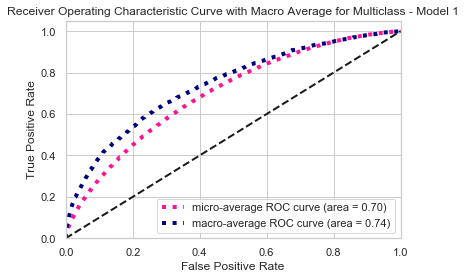

In [36]:
 y_test = label_binarize(TestLabels,classes=list(range(len(labels))))
n_classes = TestLabels.shape[1]
y_score = model.predict_proba(TestData)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with Macro Average for Multiclass - Model 1')
plt.legend(loc="lower right")
plt.show()

##### MODEL 2

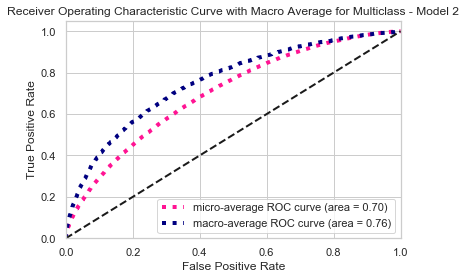

In [37]:
y_test = label_binarize(Test1Labels,classes=list(range(len(labels))))
n_classes = Test1Labels.shape[1]
y_score = predictions

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with Macro Average for Multiclass - Model 2')
plt.legend(loc="lower right")
plt.show()

##### MODEL 3

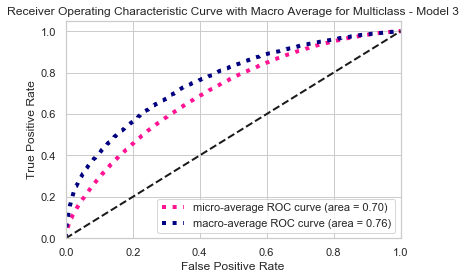

In [38]:
y_test = label_binarize(TestLabels,classes=list(range(len(labels))))
n_classes = TestLabels.shape[1]
y_score =  model2.predict_proba(TestData)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with Macro Average for Multiclass - Model 3')
plt.legend(loc="lower right")
plt.show()